Test ROC: 0.8721941977755931


Trying to unpickle estimator KMeans from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.


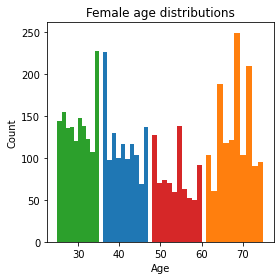

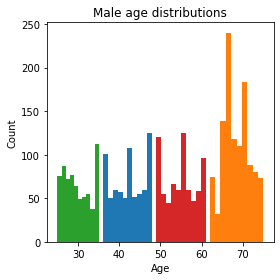

In [1]:
import xgboost, shap, os, scipy, sklearn, sys
import pandas as pd
import numpy as np
import keras, pickle

# Load data
from deepshap.data import load_nhanes, get_nhanes_feat_names
trainx, trainy, _, _, testx, testy = load_nhanes()
feat_names = get_nhanes_feat_names()

# Load model
from model import nhanes_mlp
model = nhanes_mlp()

# Get raw data and form clusters
from util import get_clusters, get_raw_trainx
raw_trainx = get_raw_trainx()
clusters, raw_clusters = get_clusters(trainx, raw_trainx)

In [7]:
raw_clusters[2]

,sex_isFemale,age,physical_activity,serum_albumin,alkaline_phosphatase,alkaline_phosphatase_isUnacceptable,alkaline_phosphatase_isTestnotdone,SGOT,SGOT_isUnacceptable,SGOT_isTestnotdone,...,urine_hematest_isBlankbutapplicable,sedimentation_rate,sedimentation_rate_isBlankbutapplicable,uric_acid,uric_acid_isUnacceptable,uric_acid_isTestnotdone,systolic_blood_pressure,pulse_pressure,weight,height
20809,False,74,2,NaN,60.0,False,False,2.09,False,False,...,False,NaN,False,4.3,False,False,184.0,90.0,46.72,157.5
27,False,72,2,4.1,NaN,False,False,NaN,False,False,...,False,21.0,False,NaN,False,False,220.0,104.0,85.62,170.2
61,False,74,4,4.5,NaN,False,False,NaN,False,False,...,False,20.0,False,NaN,False,False,126.0,52.0,79.61,175.1
80,False,71,2,3.2,NaN,False,False,NaN,False,False,...,False,38.0,False,NaN,False,False,110.0,28.0,56.81,150.3
85,False,66,4,3.9,NaN,False,False,NaN,False,False,...,False,28.0,False,NaN,False,False,166.0,70.0,86.52,164.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24951,False,67,3,NaN,45.0,False,False,2.26,False,False,...,False,NaN,False,4.9,False,False,150.0,60.0,90.15,188.7
24958,False,72,2,NaN,61.0,False,False,2.37,False,False,...,False,NaN,False,4.3,False,False,150.0,50.0,77.34,182.6
24979,False,67,2,NaN,60.0,False,False,2.44,False,False,...,False,NaN,False,6.0,False,False,160.0,60.0,84.59,179.6
24991,False,73,4,NaN,73.0,False,False,2.95,False,False,...,False,NaN,False,5.0,False,False,160.0,80.0,47.97,162.4


In [ ]:
attr_method = "deepshap"

#### Save clustered backgrounds ####
ATTR_PATH = "attr/{}_kmeans{}_clusbg_attr_lst.p".format(attr_method, n_clusters)

# Get explanations using clusters as backgrounds
if not os.path.exists(ATTR_PATH):
    
    # Get attributions for each cluster using that cluster as bg
    clus_attr_lst = []
    for clusterx in clusters:
        expl = shap.DeepExplainer(model, clusterx)
        attr = expl.shap_values(clusterx)[0]
        clus_attr_lst.append(attr)
    pickle.dump(clus_attr_lst, open(ATTR_PATH, "wb"))
else:
    clus_attr_lst = pickle.load(open(ATTR_PATH, "rb"))

#### Save random backgrounds ####
ATTR_PATH = "attr/{}_kmeans{}_randbg_attr_lst.p".format(attr_method, n_clusters)

# Get explanations using random backgrounds
if not os.path.exists(ATTR_PATH):
    rand_attr_lst = []
    
    # Randomly sample background
    np.random.seed(10)
    n = trainx.shape[0]; ref_size = 1000
    refe_inds = np.random.choice(n,ref_size,replace=False)
    refe = trainx[refe_inds]

    # Get attributions for each cluster
    for clusterx in clusters:
        expl = shap.DeepExplainer(model, refe)
        attr = expl.shap_values(clusterx)[0]
        rand_attr_lst.append(attr)
    pickle.dump(rand_attr_lst, open(ATTR_PATH, "wb"))
else:
    rand_attr_lst = pickle.load(open(ATTR_PATH, "rb"))

In [ ]:
from util import cluster_summary_plots
cluster_summary_plots(clus_attr_lst, rand_attr_lst, clusters, raw_clusters)